# Binary Planet Suppression: Toy Model

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 12)
mpl.rc('axes',labelsize = 14, linewidth=1.25)
mpl.rc('xtick',labelsize = 14)
mpl.rc('ytick',labelsize = 14)
# enable math fonts
mpl.rc('mathtext', default = 'regular')

import pickle

import pandas as pd

In [2]:
# define the radius valley
rad_valley = 1.7

### Data from Sullivan, Gaia/Bedell, KOIs, KIC

In [3]:
# read in Kendall's catalog, xmatched to all the stuff from Kepler that I need
with open('kendall+kepler.pkl', 'rb') as file:
       db = pickle.load(file)

# read in my kois table
with open('kois+gaia.pkl', 'rb') as file:
        kois = pd.read_pickle(file)

# remove the studied binaries from the all_KOI catalog
kois_less = kois[ (~kois['kepoi_name'].isin(db['kepoi_name'])) & \
                 (kois['koi_disposition']=='CONFIRMED')]
                 #(kois['koi_disposition']!='FALSE POSITIVE')]


### CKS Sample

In [4]:
tmp = Table.read('fulton2018.vot')
cks = tmp.to_pandas()
cks['kepoi_name'] = cks['KOI']
cks['KOI'] = cks['kepoi_name'].str.extract(r'K0*(\d+)\.\d+')[0].astype(int)


### Optional limit on periods

In [5]:
period_limit = False

if period_limit:
    
    plim = (db['koi_period'] > 5) & (db['koi_period'] < 30)
    kplim = (kois_less['koi_period'] > 5) & (kois_less['koi_period'] < 30)
    cksplim = (cks['Per'] > 5) & (cks['Per'] < 30)
    
else:
    
    plim = np.ones(len(db), dtype=bool)
    kplim = np.ones(len(kois_less), dtype=bool)
    cksplim = np.ones(len(cks), dtype=bool)



### Define subsamples

In [6]:
good = (db['e_Rpkep']/db['Rpkep'] < 0.15) & (db['koi_period']<100) & plim
close = db['SepAU']<100

# also remove false positives
# and "bad" parallaxes

kois_good = kois_less[(kois_less['koi_prad_err1']/kois_less['koi_prad'] < 0.15) & \
    (kois_less['koi_prad_err2']/kois_less['koi_prad'] < 0.15) & \
    (kois_less['koi_period'] < 100) & kplim]


cks_good = cks[(cks['Per'] < 100) & (cks['E_Rp']/cks['Rp'] < 0.15) & (cks['e_Rp']/cks['Rp'] < 0.15) & cksplim]


n_close = len(db['Rppri'][good & close])
n_super_earths_close = len(db['Rppri'][good & close & plim & (db['Rppri']<rad_valley)])
print("Binaries frac super-Earths: ", float(n_super_earths_close)/float(n_close))

Binaries frac super-Earths:  0.6714285714285714


# Toy Model

next up I take the kois_less (kois with good params minus any that are binaries in kendall's list) and pretend every single star is actually a binary star with a separation drawn randomly from Kendall's sample's distribution of separations. Suppress the formation of > 2 Rearth planets using the suppression model and remake the histogram. Does it work?

In [7]:

def suppression_factor(a_values):
    a_inner_true = 10  # AU (suppression 100%)
    a_outer_true = 200  # AU (suppression 0%)
    results = (np.log10(a_values) - np.log10(a_inner_true)) / (np.log10(a_outer_true) - np.log10(a_inner_true))
    return np.clip(results, a_min=0, a_max=1)

In [8]:

def planet_simulation(suppression_cat, planets_cat, join_on='kepid', prad_col='koi_prad'):

    # Number of STARS in single KOIs catalog (not planets)
    n_stars = len(suppression_cat)
    n_planets = len(planets_cat)

    # Randomly draw separations from db[close] for each star
    random_separations = np.random.choice(db[close]['SepAU'], size=n_stars, replace=True)

    # Suppress planet formation (per STAR)
    suppression_cat['my_factor'] = suppression_factor(random_separations)

    # Match STAR suppression to each PLANET
    realization = planets_cat.merge(suppression_cat, on=join_on)
    print(len(realization), n_planets)
    realization['planet_exists'] = np.zeros(n_planets, dtype=bool) 

    # Condition 1: If Rp < 1.8, planet formation is not suppressed
    realization.loc[realization[prad_col] < rad_valley, 'planet_exists'] = True

    # Condition 2: If Rp >= 1.8, planet formation probabilistically suppressed
    mask = (realization[prad_col] >= rad_valley)

    random_vals = np.random.rand(n_planets)  # uniform random [0,1) to compare to my_factor
    realization.loc[mask, 'planet_exists'] = random_vals[mask] < realization['my_factor'][mask]

    planet_radius = realization.loc[realization['planet_exists'] == 1, prad_col].to_numpy()
    n_super_earths = len(planet_radius[planet_radius < rad_valley])
    print("Frac super-Earths: ", float(n_super_earths)/float(len(planet_radius)))
    return(planet_radius)



### Suppress the KOI sample

In [9]:
# Holder for the random separations for the STARS
d = {'kepid': kois_good['kepid'].unique()}
suppression_cat = pd.DataFrame(data=d)

koi_prad_sim = planet_simulation(suppression_cat, kois_good, join_on='kepid', prad_col='koi_prad')


1088 1088
Frac super-Earths:  0.5597826086956522


### Suppress the CKS sample

In [10]:
# Holder for the random separations for the STARS
d = {'KOI': cks_good['KOI'].unique()}
suppression_cat = pd.DataFrame(data=d)

cks_prad_sim = planet_simulation(suppression_cat, cks_good, join_on='KOI', prad_col='Rp')

1594 1594
Frac super-Earths:  0.606244579358196


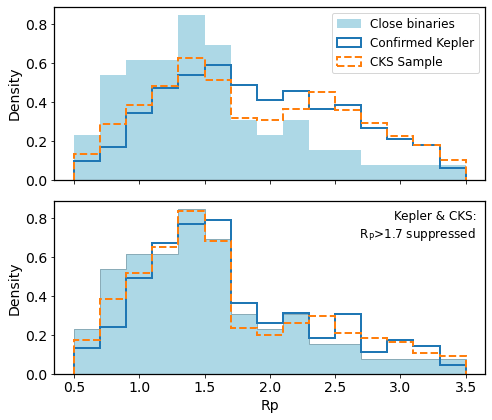

In [11]:

    

fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True, sharey=True)
histrange=[0.5,3.5]
nbins=15

# planets with good radii in binary systems with rho<100 au and planet period < 100 days
axes[0].hist(db['Rppri'][good & close & plim], 
             range=histrange, bins=nbins, density=True, 
         histtype='stepfilled', color='lightblue',
        label='Close binaries')
axes[1].hist(db['Rppri'][good & close & plim], 
             range=histrange, bins=nbins, density=True, 
             histtype='stepfilled', color='lightblue' )

# compared to the kois that are at least not definite binaries with good radii and per<100 days
axes[0].hist(kois_good['koi_prad'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2,
        label='Confirmed Kepler')

# compared to the cks
axes[0].hist(cks_good['Rp'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step',lw=2, linestyle='--', 
        label='CKS Sample')

axes[0].set_ylabel('Density')
axes[0].legend()

if period_limit:
    axes[0].text(0.1,0.95, '$5<P_P(d)<30$')

# planets with good radii in binary systems with rho<100 au and planet period < 100 days
axes[1].hist(db['Rppri'][good & close & plim], 
             range=histrange, bins=nbins, density=True, 
             histtype='stepfilled', color='lightblue' )
axes[1].hist(db['Rppri'][good & close & plim], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', color='#8aacb8')


# compared to the kois that exist in simulation still
axes[1].hist(koi_prad_sim, 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2) 

axes[1].hist(cks_prad_sim, 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, linestyle='--')

axes[1].text(0.98, 0.95, 'Kepler & CKS:\n $R_P$>1.7 suppressed ',
     horizontalalignment='right',
     verticalalignment='top',
     transform = axes[1].transAxes)
    
plt.xlabel('Rp')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('suppression_sim.pdf')